<a href="https://colab.research.google.com/github/omkar-salunke/Trading_algos/blob/main/Fama_French_Factor_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
from zipfile import ZipFile
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
import yfinance as yahooFinance
import datetime
%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
!wget "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

In [3]:
!unzip /content/F-F_Research_Data_Factors_CSV.zip

In [4]:
FFdata = pd.read_csv('/content/F-F_Research_Data_Factors.CSV', 
                     header = 0, names = ['Date','MKT-RF','SMB','HML','RF'], 
                     skiprows=3)

#Drop last row of data - String
FFdata = FFdata[:1074]

#Convert YYYYMM into Date
FFdata['Date'] = pd.to_datetime(FFdata['Date'], format = "%Y%m")
FFdata.index = FFdata['Date']
FFdata.drop(FFdata.columns[0], axis=1,inplace=True)

#Drop Days in YYYY-MM-DD
FFdata.index = FFdata.index.map(lambda x: x.strftime('%Y-%m'))

#Convert into float
FFdata = FFdata.astype('float')
FFdata.tail()

,MKT-RF,SMB,HML,RF
Date,,,,
2015-08,-6.04,0.44,2.73,0.00
2015-09,-3.07,-2.61,0.39,0.00
2015-10,7.75,-1.98,-0.25,0.00
2015-11,0.56,3.68,-0.49,0.00
2015-12,-2.17,-2.86,-2.45,0.01


In [5]:
#Get Data from Yahoo
# startDate 
startDate = datetime.datetime(1950, 1, 1)
 
# endDate 
endDate = datetime.datetime(2016, 1, 1)
GetInformation = yahooFinance.Ticker("TBGVX")
 

f=GetInformation.history(start=startDate,
                                     end=endDate,interval = "1mo")
f.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-07-01,6.612176,6.823765,6.612176,6.823765,0.0,0.0,0
1993-08-01,6.836988,7.088251,6.836988,7.075026,0.0,0.0,0
1993-09-01,7.075027,7.075027,6.803928,6.817153,0.0,0.0,0
1993-10-01,6.823763,7.075026,6.823763,7.075026,0.0,0.0,0
1993-11-01,7.061803,7.108088,7.002293,7.081639,0.0,0.0,0


In [6]:
#Fix Date Column
f.index = f.index.map(lambda x: x.strftime('%Y-%m'))
#Ln Return
f['LnReturn'] = np.log(f['Close']) - np.log(f['Close'].shift(1))
f.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,LnReturn
Date,,,,,,,,
1993-07,6.612176,6.823765,6.612176,6.823765,0.0,0.0,0,NaN
1993-08,6.836988,7.088251,6.836988,7.075026,0.0,0.0,0,0.036160
1993-09,7.075027,7.075027,6.803928,6.817153,0.0,0.0,0,-0.037129
1993-10,6.823763,7.075026,6.823763,7.075026,0.0,0.0,0,0.037129
1993-11,7.061803,7.108088,7.002293,7.081639,0.0,0.0,0,0.000934


In [7]:
Filter_f = FFdata.loc[f.index.to_list()]

In [8]:
#Merge DF
data2 = pd.concat([f,Filter_f], axis = 1)

#Excess Return
data2['XRtrn'] = (data2['LnReturn']*100 - data2['RF'])
#Align Data
df = data2[np.isfinite(data2['XRtrn'])]

df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,LnReturn,MKT-RF,SMB,HML,RF,XRtrn
Date,,,,,,,,,,,,,
2015-08,25.064097,25.194493,23.182659,23.983667,0.0,0.0,0,-0.042576,-6.04,0.44,2.73,0.00,-4.257571
2015-09,23.564530,24.020919,23.015001,23.303738,0.0,0.0,0,-0.028759,-3.07,-2.61,0.39,0.00,-2.875931
2015-10,23.322369,24.635649,23.322369,24.551823,0.0,0.0,0,0.052172,7.75,-1.98,-0.25,0.00,5.217233
2015-11,24.579765,24.644964,24.058179,24.449369,0.0,0.0,0,-0.004182,0.56,3.68,-0.49,0.00,-0.418167
2015-12,24.514565,24.514565,22.782152,22.782152,0.0,0.0,0,-0.070627,-2.17,-2.86,-2.45,0.01,-7.072700


In [9]:
y = df['XRtrn']
X = df.iloc[:,[8,9,10]]
X = sm.add_constant(X)


model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  XRtrn   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     79.71
Date:                Sun, 29 Aug 2021   Prob (F-statistic):           5.15e-36
Time:                        12:12:33   Log-Likelihood:                -610.55
No. Observations:                 249   AIC:                             1229.
Df Residuals:                     245   BIC:                             1243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3483      0.183     -1.898      0.0

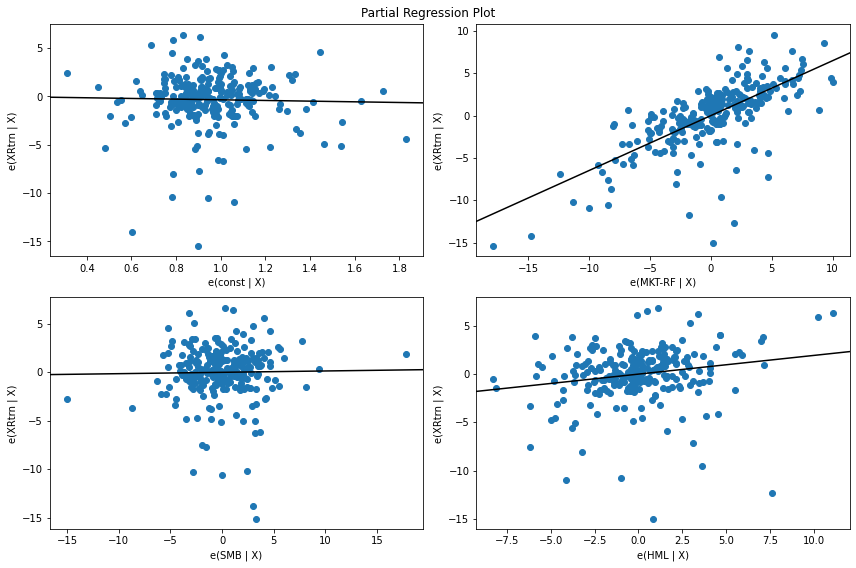

In [10]:

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig = fig)
plt.show()